# Cobb Detection Using Keras

---

Author: Mohammad Arabzadeh

In [2]:
!pip install -q tfa-nightly
!git clone https://github.com/bckenstler/CLR.git
import copy
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn import tree
from CLR.clr_callback import CyclicLR
from sklearn.model_selection import StratifiedKFold

In [3]:
raw_data = pd.read_excel('/content/traindataset_for_intro_to_ml.xlsx').iloc[: , 1:]

## Data Observation

Plotting targets based on each other

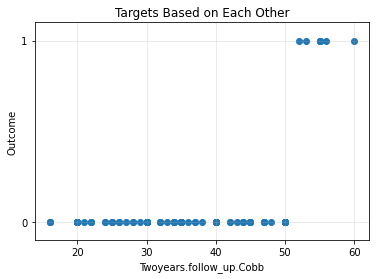

In [26]:
plt.figure()

plt.scatter(raw_data['Twoyears.follow_up.Cobb'], raw_data['Outcome'])
plt.xlabel('Twoyears.follow_up.Cobb')
plt.ylabel('Outcome')
plt.title("Targets Based on Each Other")
plt.yticks([0, 1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.3)

plt.show()


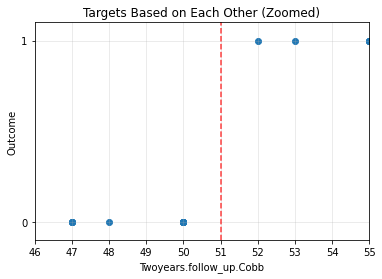

In [27]:
plt.figure()

plt.scatter(raw_data['Twoyears.follow_up.Cobb'], raw_data['Outcome'])
plt.plot([51, 51], [-1, 2], 'r--', alpha=0.75)
plt.xlabel('Twoyears.follow_up.Cobb')
plt.ylabel('Outcome')
plt.title("Targets Based on Each Other (Zoomed)")
plt.yticks([0, 1])
plt.xlim([46, 55])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.3)

plt.show()

Plotting target histograms

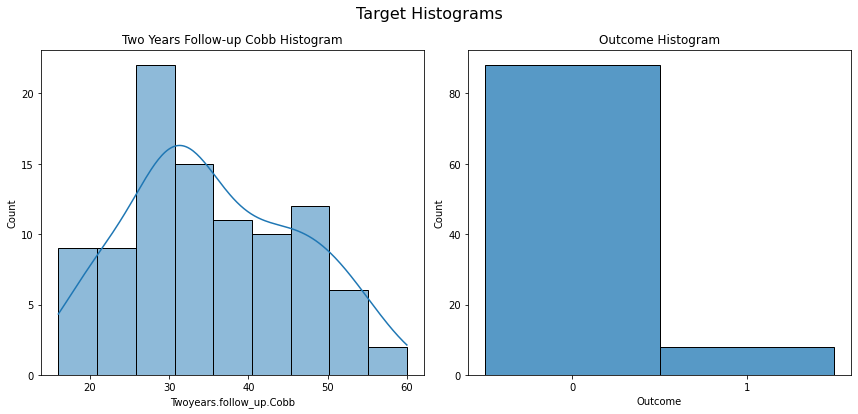

In [28]:
fig, ax = plt.subplots(1, 2)
fig.set_figheight(2*3)
fig.set_figwidth(3*4)

# Two Years Follow-up Cobb
sns.histplot(raw_data, x='Twoyears.follow_up.Cobb', bins=9, kde=True, ax=ax[0])
ax[0].set_title("Two Years Follow-up Cobb Histogram")

# Outcome
sns.histplot(raw_data, x='Outcome', bins=2, binrange=(-0.5, 1.5), ax=ax[1])
ax[1].set_title("Outcome Histogram")
ax[1].set_xticks([0, 1])

fig.suptitle("Target Histograms", fontsize=16)
fig.tight_layout(pad=1, rect=[0, 0.03, 1, 0.94])
plt.show()

Samples with Outcome = 1

In [29]:
raw_data.loc[raw_data['Outcome'] == 1]

,Gender,Bracing_age,Before.bracing.Cobb,C_DAR,Bracing.Risser.sign,Best.In_brace.Correction,Twoyears.follow_up.Cobb,Outcome
33,2,13,45,4.30,1,33.333333,55,1
35,1,11,45,11.25,0,15.555556,55,1
37,2,12,45,7.50,1,11.111111,55,1
38,2,12,40,10.00,1,17.500000,55,1
60,2,12,40,8.00,2,20.000000,52,1
76,2,11,30,6.00,1,33.333333,53,1
89,2,10,45,5.60,0,11.111111,60,1
91,2,10,30,10.00,0,33.333333,56,1


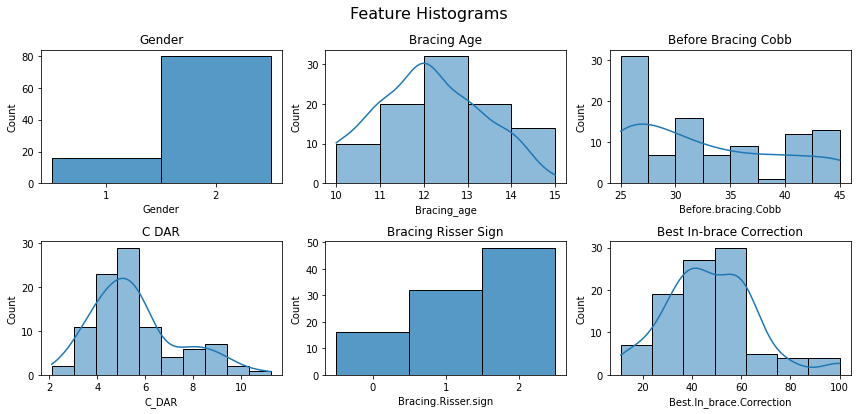

In [30]:
fig, ax = plt.subplots(2, 3)
fig.set_figheight(2*3)
fig.set_figwidth(3*4)

# Gender
sns.histplot(raw_data, x='Gender', bins=2, binrange=(0.5, 2.5), ax=ax[0, 0])
ax[0, 0].set_xticks([1, 2])
ax[0, 0].set_title("Gender")

# Bracing Age
sns.histplot(raw_data, x='Bracing_age', bins=5, kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Bracing Age")

# Before Bracing Cobb
sns.histplot(raw_data, x='Before.bracing.Cobb', kde=True, ax=ax[0, 2])
ax[0, 2].set_title("Before Bracing Cobb")

# C DAR
sns.histplot(raw_data, x='C_DAR', bins=10, kde=True, ax=ax[1, 0])
ax[1, 0].set_title("C DAR")

# Bracing Risser Sign
sns.histplot(raw_data, x='Bracing.Risser.sign', bins=3, binrange=(-0.5, 2.5), ax=ax[1, 1])
ax[1, 1].set_xticks([0, 1, 2])
ax[1, 1].set_title("Bracing Risser Sign")

# Best In-brace Correction
sns.histplot(raw_data, x='Best.In_brace.Correction', bins=7, kde=True, ax=ax[1, 2])
ax[1, 2].set_title("Best In-brace Correction")

fig.suptitle("Feature Histograms", fontsize=16)
fig.tight_layout(pad=1, rect=[0, 0.03, 1, 0.94])
plt.show()

## Preprocessing

In [31]:
# One-hot encoding Bracing Risser Sign
data = pd.get_dummies(raw_data, prefix='Bracing.Risser.sign', columns=['Bracing.Risser.sign'])
cols = data.columns.tolist()
cols = cols[:5] + cols[7:] + cols[5:7]
data = data[cols]

# Mapping Gender to {0, 1}
data['Gender'] = data['Gender'] - 1

# Normalizing other features and Two Years Follow-up Cobb target
cols = data.columns.tolist()
cols = cols[1:5] + cols[8:9]
data[cols] = (data[cols] - data[cols].min()) / (data[cols].max() - data[cols].min())

In [32]:
data.sample(5)

,Gender,Bracing_age,Before.bracing.Cobb,C_DAR,Best.In_brace.Correction,Bracing.Risser.sign_0,Bracing.Risser.sign_1,Bracing.Risser.sign_2,Twoyears.follow_up.Cobb,Outcome
13,1,0.6,0.05,0.338798,0.567308,0,0,1,0.318182,0
11,1,0.0,0.75,0.644809,0.156250,0,1,0,0.590909,0
87,1,0.8,0.45,0.382514,0.338235,0,1,0,0.545455,0
80,1,0.2,0.25,0.426230,0.325000,0,1,0,0.704545,0
20,1,0.4,0.75,0.491803,0.156250,0,1,0,0.772727,0


In [33]:
# Convert dataframe to numpy array
X = data.iloc[:, :-2].to_numpy()

y_reg = data.iloc[:, -2].to_numpy()
y_cls = data.iloc[:, -1].to_numpy()

## Decision Tree Demonstraition for Classification

In [12]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(raw_data['Twoyears.follow_up.Cobb'].to_numpy().reshape((-1, 1)), raw_data['Outcome'].to_numpy())

[Text(167.4, 163.07999999999998, 'X[0] <= 51.0\nentropy = 0.414\nsamples = 96\nvalue = [88, 8]'),
 Text(83.7, 54.360000000000014, 'entropy = 0.0\nsamples = 88\nvalue = [88, 0]'),
 Text(251.10000000000002, 54.360000000000014, 'entropy = 0.0\nsamples = 8\nvalue = [0, 8]')]

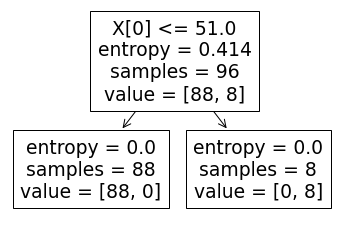

In [13]:
tree.plot_tree(clf)

## Regression Hyper-parameter Tuning

In [15]:
def make_reg_net(neurons, activation, hidden_layers, batch_norm, dropout, dropout_rate, regularizer):
    """Function to make a model dynamically based on the input arguments
    """
    model = tf.keras.models.Sequential(name='reg_net')

    model.add(tf.keras.layers.Input(shape=X.shape[1], name='input_layer'))
    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization(name='batch_norm'))

    model.add(tf.keras.layers.Dense(units=neurons, kernel_regularizer=regularizer, activation=activation, name='hidden_1'))
    
    if dropout:
        model.add(tf.keras.layers.Dropout(dropout_rate, name='dropout_1'))
    
    for i in range(hidden_layers-1):
        model.add(tf.keras.layers.Dense(units=neurons, kernel_regularizer=regularizer, activation=activation, name=f'hidden_{i+2}'))
        if dropout:
            model.add(tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+2}'))

    model.add(tf.keras.layers.Dense(1, activation='linear', name='output_layer'))
    return model


In [ ]:
def tune_reg_model(
    X,
    y_reg,
    y_cls,
    model_builder=make_reg_net,
    epochs=50,
    batch_size=64,
    activation='relu',
    neurons=10,
    hidden_layers=1,
    optimizer='rmsprop',
    learning_rate=0.01,
    batch_norm=False,
    dropout=False,
    dropout_rate=None,
    regularizer=None,
    callbacks=None,
    plot_val=True,
    title=None,
    legend=None,
    rmse_log_scale=False,
    folds=8,
    seed=1400,
):
    """Function to compare different hyper-parameters. Example is given in the next code cell. 
    """
    # save input hyperparameters
    KWARGS = locals()

    # delete unwanted parameters
    KWARGS.pop('X')
    KWARGS.pop('y_reg')
    KWARGS.pop('y_cls')
    KWARGS.pop('model_builder')
    KWARGS.pop('plot_val')
    KWARGS.pop('title')
    KWARGS.pop('legend')
    KWARGS.pop('rmse_log_scale')

    # initialize model variable
    model = None

    for key, val in KWARGS.items():
        if isinstance(val, (list, tuple)):
            # initialize the plots
            fig, ax = plt.subplots(1, 2)
            fig.set_figheight(5)
            fig.set_figwidth(2*6)

            for count, v in enumerate(val):
                print(f"Training on {key}: {v}")

                # make a new kwargs with the current item
                kwargs = copy.copy(KWARGS)
                kwargs[key] = v

                # kfold initialization
                skf = StratifiedKFold(
                    n_splits=kwargs['folds'],
                    shuffle=True,
                    random_state=kwargs['seed'],
                )

                # initialize history variable
                hist = None

                # do k-fold
                for idx_train, idx_val in skf.split(X, y_cls):
                    # set optimizer
                    if isinstance(kwargs['optimizer'], str):
                        # case when the string representation of the optimizer was passed
                        opt = tf.keras.optimizers.get(kwargs['optimizer'])
                        opt.learning_rate = kwargs['learning_rate']
                    else:
                        # case when an optimizer object was passed
                        opt = kwargs['optimizer']
                    
                    # progress bar
                    print("#", end='')

                    # create a model
                    model = model_builder(
                        neurons=kwargs['neurons'],
                        activation=kwargs['activation'],
                        hidden_layers=kwargs['hidden_layers'],
                        batch_norm=kwargs['batch_norm'],
                        dropout=kwargs['dropout'],
                        dropout_rate=kwargs['dropout_rate'],
                        regularizer=kwargs['regularizer'],
                    )

                    # compile the model
                    model.compile(
                        optimizer=opt,
                        loss='mean_squared_error',
                        metrics=[
                                 tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                                 tfa.metrics.RSquare(name='r2', dtype=tf.float32, y_shape=(1,)),
                        ]
                    )

                    # fit the model
                    history = model.fit(
                        X[idx_train],
                        y_reg[idx_train],
                        validation_data=(X[idx_val], y_reg[idx_val]),
                        epochs=kwargs['epochs'],
                        batch_size=kwargs['batch_size'],
                        callbacks=kwargs['callbacks'],
                        verbose=0,
                    )

                    # add up the new history results
                    if hist is None:
                            metrics = model.metrics_names
                            metrics += ['val_' + metric for metric in metrics]
                            hist = {key: np.zeros(kwargs['epochs']) for key in metrics}
                    for metric in metrics:
                        hist[metric] += np.array(history.history[metric])

                # end the progress bar line
                print("")
                
                # average the history results
                for metric in metrics:
                    hist[metric] /= kwargs['folds']

                # make an string representation of the tuning parameter
                if key == 'callbacks':
                    if v:
                        v_str = "with"
                    else:
                        v_str = "without"
                else:
                    v_str = str(v)
                
                # plot the metric results on the training dataset
                ax[0].plot(hist['rmse'], color='C'+str(count), label='train '+v_str+' '+key, )
                ax[1].plot(hist['r2'], color='C'+str(count), label='train '+v_str+' '+key, )
                
                # plot the metric results on the validation dataset
                if plot_val:
                    ax[0].plot(np.concatenate(([np.nan], hist['val_rmse'])), linestyle='--', color='C'+str(count), label='val '+v_str+' '+key, )
                    ax[1].plot(np.concatenate(([np.nan], hist['val_r2'])), linestyle='--', color='C'+str(count), label='val '+v_str+' '+key, )
            
            # apply the plotting options
            if legend is None:
                ax[0].legend()
                ax[1].legend()
            # rmse
            ax[0].set_xlabel('Epoch')
            ax[0].set_ylabel('RMSE')
            ax[0].grid(which='both', alpha=0.3)
            if rmse_log_scale:
                ax[0].set_yscale('log')
                ax[0].set_ylabel('RMSE (log scale)')
            # r2 score
            ax[1].set_xlabel('Epoch')
            ax[1].set_ylabel('$R^2$ Score')
            ax[1].set_ylim([0, 1])
            ax[1].grid(alpha=0.3)

            if title is None:
                title = "Regression with Different '" + key + "' Values"

            fig.suptitle(title, fontsize=16)
            fig.tight_layout(pad=1, rect=[0, 0.03, 1, 0.94])
            fig.show()

            # print the parameters that the models were trained on
            print(KWARGS)
    return model

Training on epochs: 5000
########
{'epochs': [5000], 'batch_size': 128, 'activation': 'relu', 'neurons': 500, 'hidden_layers': 4, 'optimizer': 'adam', 'learning_rate': 0.0008, 'batch_norm': True, 'dropout': False, 'dropout_rate': None, 'regularizer': <keras.regularizers.L2 object at 0x7f2b251cd710>, 'callbacks': <CLR.clr_callback.CyclicLR object at 0x7f2b251cda10>, 'folds': 8, 'seed': 1400}


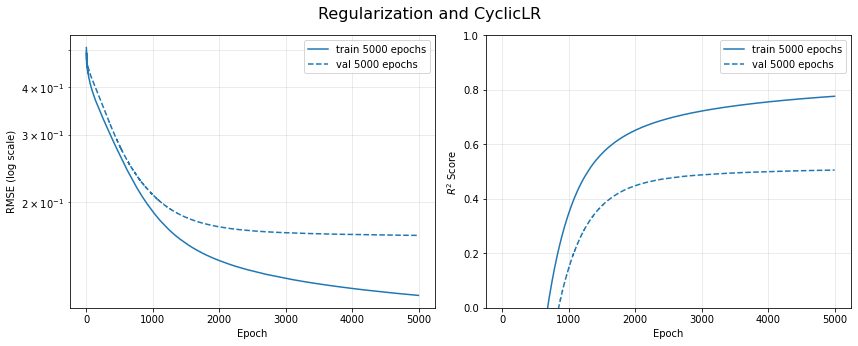

In [ ]:
model = tune_reg_model(
    X,
    y_reg,
    y_cls,
    optimizer='adam',
    epochs=[5000],
    batch_size=128,
    learning_rate=8e-4,
    activation='relu',
    neurons=500,
    folds=8,
    callbacks=CyclicLR(base_lr=1e-6, max_lr=3e-3, step_size=8, mode='exp_range', gamma=0.999),
    plot_val=True,
    title="Regularization and CyclicLR",
    hidden_layers=4,
    batch_norm=True,
    regularizer=tf.keras.regularizers.L2(l2=0.006),
    rmse_log_scale=True,
)


### Learning Rate Optimizer (Range Test)

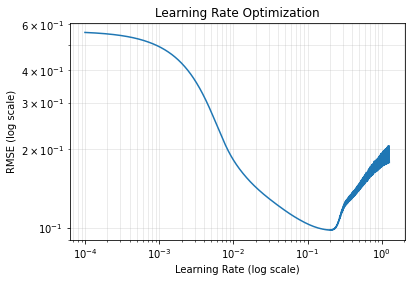

In [16]:
RATE = 1.01

# learning rate optimizer
def lr_optimizer_scheduler(epoch, lr):
    return lr * RATE

def lr_optimizer(**kwargs):
    """Function to implement the learning rate range test.
    """
    # set the optimizer
    opt = tf.keras.optimizers.get(kwargs['optimizer'])
    opt.learning_rate = kwargs['learning_rate']

    # create a model
    model = kwargs['model_builder'](
                    neurons=kwargs['neurons'],
                    activation=kwargs['activation'],
                    hidden_layers=kwargs['hidden_layers'],
                    batch_norm=kwargs['batch_norm'],
                    dropout=kwargs['dropout'],
                    dropout_rate=kwargs['dropout_rate'],
                    regularizer=kwargs['regularizer'],
                )
    
    # compile the model
    model.compile(
                    optimizer=opt,
                    loss='mean_squared_error',
                    metrics=[
                             tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                             tfa.metrics.RSquare(name='r2', dtype=tf.float32, y_shape=(1,)),
                    ]
                )
    
    # fit the model
    history = model.fit(
        kwargs['X'],
        kwargs['y_reg'],
        epochs=kwargs['epochs'],
        batch_size=kwargs['batch_size'],
        callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_optimizer_scheduler)],
        verbose=0,
    )
    
    # make an array of learning rate values
    lr = np.array([kwargs['learning_rate']*(RATE**n) for n in range(kwargs['epochs'])])

    # plot the results
    plt.figure()
    plt.plot(lr, history.history['rmse'], label='rmse')
    plt.xlabel("Learning Rate (log scale)")
    plt.ylabel("RMSE (log scale)")
    plt.title("Learning Rate Optimization")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(which='both', alpha=0.3)
    plt.show()


lr_optimizer(
    X=X,
    y_reg=y_reg,
    model_builder=make_reg_net,
    epochs=950,
    batch_size=128,
    activation='relu',
    neurons=500,
    optimizer='adadelta',
    learning_rate=1e-4,
    hidden_layers=4,
    batch_norm=True,
    dropout=False,
    dropout_rate=0.0,
    regularizer=tf.keras.regularizers.L2(l2=0.006),
)


## Fitting The Final Model

In [ ]:
# Tuned Parameters
MODEL_KWARGS = dict(
    neurons=500,
    activation='relu',
    hidden_layers=4,
    batch_norm=True,
    regularizer=tf.keras.regularizers.L2(l2=0.006),
    dropout=False,
    dropout_rate=0,
)

FIT_KWARGS = dict(
    optimizer='adam',
    epochs=20000,
    batch_size=128,
    learning_rate=8e-4,
    callbacks=CyclicLR(base_lr=1e-6, max_lr=3e-3, step_size=8, mode='exp_range', gamma=0.999),
)

In [ ]:
def final_reg_fit(
    X,
    y,
    model,
    optimizer,
    epochs,
    batch_size,
    learning_rate,
    callbacks,
    verbose='auto',
):
    """Function to fit the final model with the tuned hyper-parameters.
    """
    # Set the optimizer
    opt = tf.keras.optimizers.get(optimizer)
    opt.learning_rate = learning_rate
    
    # Compile the model
    model.compile(
        optimizer=opt,
        loss='mean_squared_error',
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tfa.metrics.RSquare(name='r2', dtype=tf.float32, y_shape=(1,)),
        ]
    )

    # Fit the model
    history = model.fit(
        X,
        y,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose,
    )

    return history


In [ ]:
model = make_reg_net(**MODEL_KWARGS)
model.summary()

Model: "reg_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_norm (BatchNormalizat  (None, 8)                32        
 ion)                                                            
                                                                 
 hidden_1 (Dense)            (None, 500)               4500      
                                                                 
 hidden_2 (Dense)            (None, 500)               250500    
                                                                 
 hidden_3 (Dense)            (None, 500)               250500    
                                                                 
 hidden_4 (Dense)            (None, 500)               250500    
                                                                 
 output_layer (Dense)        (None, 1)                 501       
                                                           

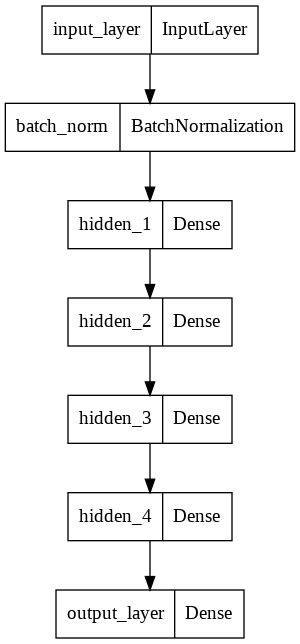

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
hist = final_reg_fit(X, y_reg, model, **FIT_KWARGS)

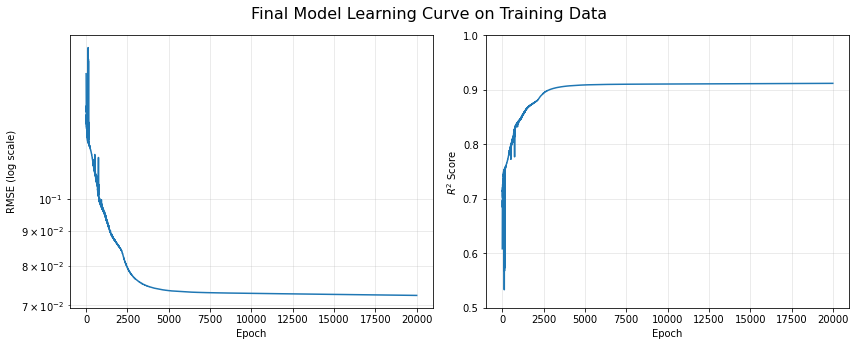

In [ ]:
# plot the final results
fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(2*6)


ax[0].plot(hist.history['rmse'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('RMSE (log scale)')
ax[0].set_yscale('log')
ax[0].grid(which='both', alpha=0.3)

ax[1].plot(hist.history['r2'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('$R^2$ Score')
ax[1].set_ylim(bottom=0.5, top=1)
ax[1].grid(which='both', alpha=0.3)


fig.suptitle("Final Model Learning Curve on Training Data", fontsize=16)
fig.tight_layout(pad=1, rect=[0, 0.03, 1, 0.94])
fig.show()


In [ ]:
# save the model
# model.save("reg_model")

## Evaluation

In [91]:
# unzip the model file if it is zipped
# !unzip reg_model.zip

In [4]:
# predicted labels
from predict import test
y_reg_hat, y_cls_hat = test('/content/traindataset_for_intro_to_ml.xlsx')

In [5]:
# true labels
y_reg = raw_data.iloc[:, -2].to_numpy()
y_cls = raw_data.iloc[:, -1].to_numpy()

### Regression Performance on the Training Dataset

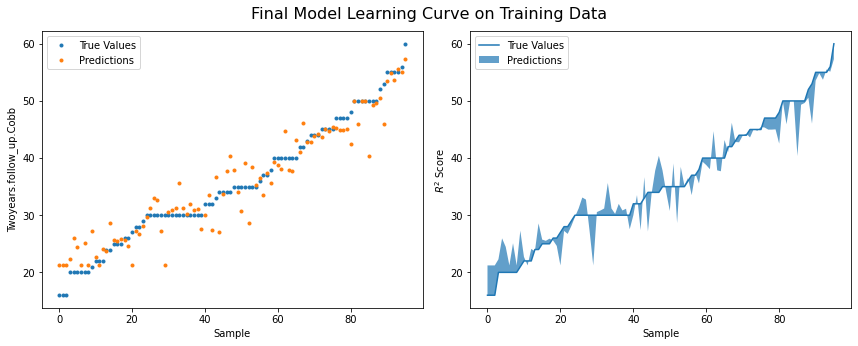

In [6]:
# plot the label predictions
fig, ax = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(2*6)

ax[0].plot(y_reg[np.argsort(y_reg)], '.')
ax[0].plot(y_reg_hat.reshape((-1))[np.argsort(y_reg)], '.')
ax[0].set_xlabel('Sample')
ax[0].set_ylabel('Twoyears.follow_up.Cobb')
ax[0].legend(['True Values', 'Predictions'])
# ax[0].grid(axis='y', alpha=0.3)

ax[1].plot(y_reg[np.argsort(y_reg)])
ax[1].fill_between(list(range(len(y_reg_hat.reshape((-1))[np.argsort(y_reg)]))), y_reg_hat.reshape((-1))[np.argsort(y_reg)], y_reg[np.argsort(y_reg)], alpha=0.7)
ax[1].set_xlabel('Sample')
ax[1].set_ylabel('$R^2$ Score')
ax[1].legend(['True Values', 'Predictions'])

# ax[1].grid(which='both', alpha=0.3)


fig.suptitle("Final Model Learning Curve on Training Data", fontsize=16)
fig.tight_layout(pad=1, rect=[0, 0.03, 1, 0.94])
fig.show()


In [7]:
r2 = sklearn.metrics.r2_score(y_reg, y_reg_hat)

print(f"R2 Score on the Training Dataset: {r2:.3f}")

R2 Score on the Training Dataset: 0.912


### Classification Performance on the Training Dataset

In [87]:
# Classification Report
print(sklearn.metrics.classification_report(y_cls, y_cls_hat))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        88
           1       0.88      0.88      0.88         8

    accuracy                           0.98        96
   macro avg       0.93      0.93      0.93        96
weighted avg       0.98      0.98      0.98        96



<Figure size 432x288 with 0 Axes>

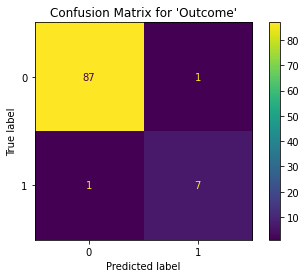

In [90]:
# Confusion Matrix
plt.figure()
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_cls, y_cls_hat)).plot()
plt.title("Confusion Matrix for 'Outcome'")
plt.show()